In [2]:
#utils.install_packages('package')

import rpy2
from rpy2.robjects.packages import importr

base = importr('base')
utils = importr('utils')
graphics = importr('graphics')
stats    = importr('stats')
grdevices = importr('grDevices')
from rpy2.robjects.lib import grdevices
lattice = importr('lattice')
ggplot2 = importr('ggplot2')
limma = importr('limma')
edger = importr('edgeR')

import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import FloatVector as c
from rpy2.robjects.vectors import DataFrame
from rpy2.robjects import globalenv as var 
rprint = robjects.globalenv.get("print")

r = robjects.r

from IPython.display import Image, display

print(rpy2.__version__)
print(r('.libPaths()')[0])

D:\Users\Emperor Justinian\Anaconda\lib\site-packages\rpy2\robjects\packages.py:347: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn("The symbol '%s' is not in this R namespace/package." % name)


2.8.6
D:/Users/Emperor Justinian/Anaconda/envs/tensorflowprojects/R/library


In [35]:
def render(x=None, y=None, width=1024, height=896, res=150, col='green', main='Scatterplot', xlab='plantd', ylab='cobw', pch=19, plot='plot'):

    with grdevices.render_to_bytesio(grdevices.png, 
                                     width=width,
                                     height=height, 
                                     res=res) as img:
        rcommand = str('{0}').format(str(x))
        if plot == 'plot':
            graphics.plot(x, y, col=col, main=main, xlab=xlab, ylab=ylab, pch=pch)
        if plot == 'box':
            graphics.boxplot(x, col=col, main=main, xlab=xlab, ylab=ylab, pch=pch)
        if plot == 'biplot':
            stats.biplot(x)
        if plot == 'hclust':
            #clust = stats.hclust(x)
            r('clust <- hclust(dist(t(m), method="eu"))')
            clust = var["clust"]
            graphics.plot(clust)
        if plot == 'prcomp':
            r('pr <- prcomp(' + rcommand + ', centre=TRUE, scale.=TRUE)')
            pr = var["pr"]
            graphics.plot(pr)
        if plot == 'plotMDS':
            r('countmds <- plotMDS(countlist)')
        if plot == 'plotMeanVar':
            r("plotMeanVar("+ rcommand +")")
        if plot == 'plotBCV':
            r("plotBCV("+ rcommand +")")
        if plot == 'plotSmear':
            r("plotSmear("+ rcommand +", de.tags=Genes)")
            graphics.abline(h=r('c(-1, 1)'), col=2)
   
    display(Image(data=img.getvalue(), format='png', embed=True))
    
#r("plantd")

In [56]:
r('fDir <- "/Users/Emperor Justinian/Jupyter Notebooks/Bio-Inf R/"')

r('cnts <- read.delim(paste0(fDir,"SRR898768X_CountMatrix.txt.csv"), header=TRUE, sep=",")') #Ik heb '# Todt (c)' uit de txt verwijderd ivm errors
#RNA-Seq-counts.txt
#SRR898768X_CountMatrix.txt
r('cnts <- cnts[,-1]')

r('m <- as.matrix(cnts)')
print(r('head(m)'))      

     SRR8987684 SRR8987685 SRR8987686

[1,]          0          0          0

[2,]          0         66          0

[3,]          0         14          0

[4,]          1        268          1

[5,]          0        129          0

[6,]          0         68          0



In [57]:
print(r('summary(m)'))

   SRR8987684         SRR8987685        SRR8987686      

 Min.   :       0   Min.   :      0   Min.   :       0  

 1st Qu.:       0   1st Qu.:      4   1st Qu.:       0  

 Median :       0   Median :     87   Median :       0  

 Mean   :    1599   Mean   :   1621   Mean   :    1538  

 3rd Qu.:       1   3rd Qu.:   1112   3rd Qu.:       1  

 Max.   :32209806   Max.   :2410124   Max.   :30531600  



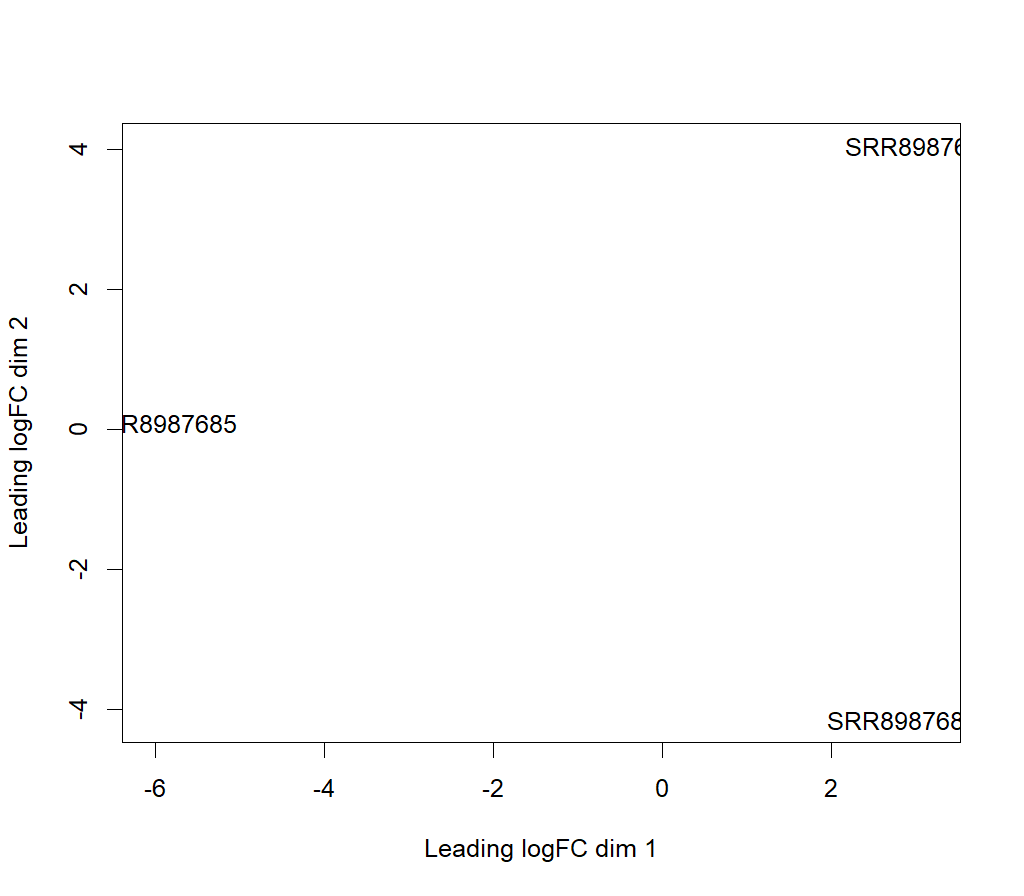

In [58]:
#r('group <- factor(c(1,1,2,2,1,1,2,2))') # for testdata
r('group <- factor(c(1,1,2))')
r('countlist <- DGEList(counts=cnts, group=group)')
r('keep <- filterByExpr(countlist)') 
r('countlist <- countlist[keep, keep.lib.sizes=FALSE]')
r('countlist <- calcNormFactors(countlist, method="TMM")') # Possibly add Yuen's t-test
render(r('countlist'), main='mds', plot='plotMDS')
r('design <- model.matrix(~group)')
r('GLMcomdisp <- estimateGLMCommonDisp(countlist, design)')
r('GLMtrenddisp <- estimateGLMTrendedDisp(countlist, design)')
r('GLMtagdisp <- estimateGLMTagwiseDisp(GLMcomdisp, design)')
r('countlist <- estimateDisp(countlist)');

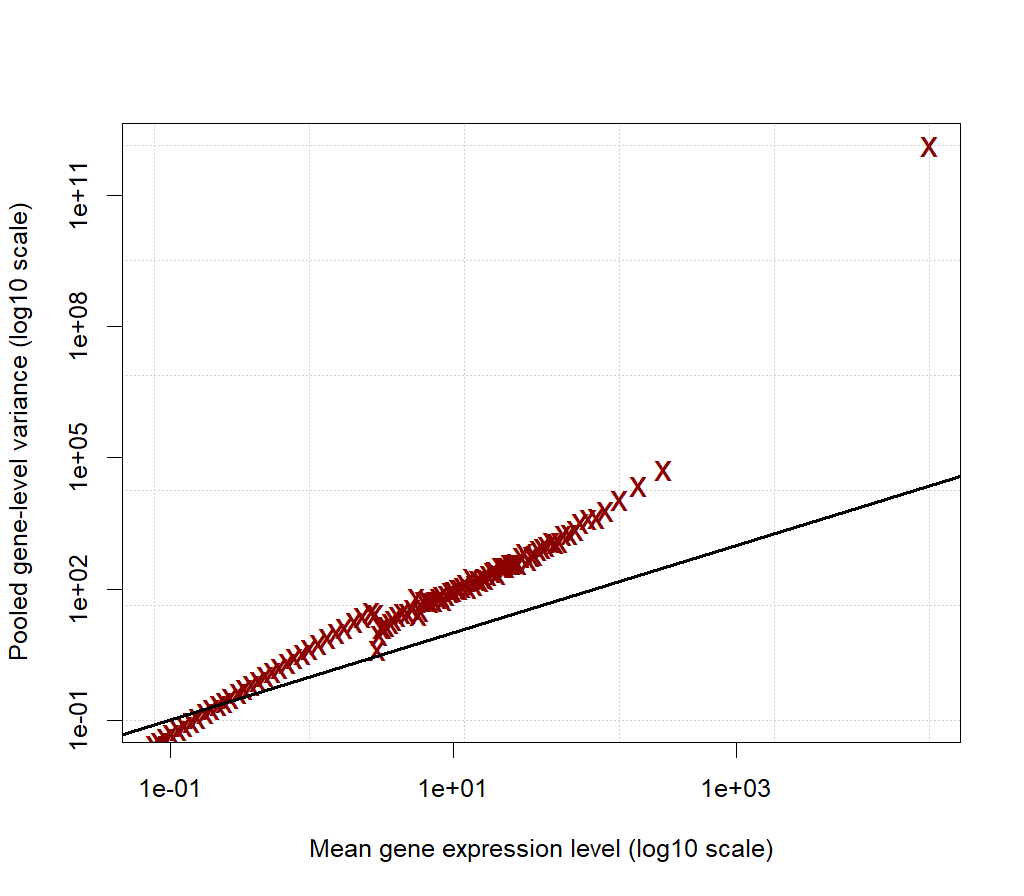

In [59]:
render('GLMcomdisp', main='mean var', plot='plotMeanVar')

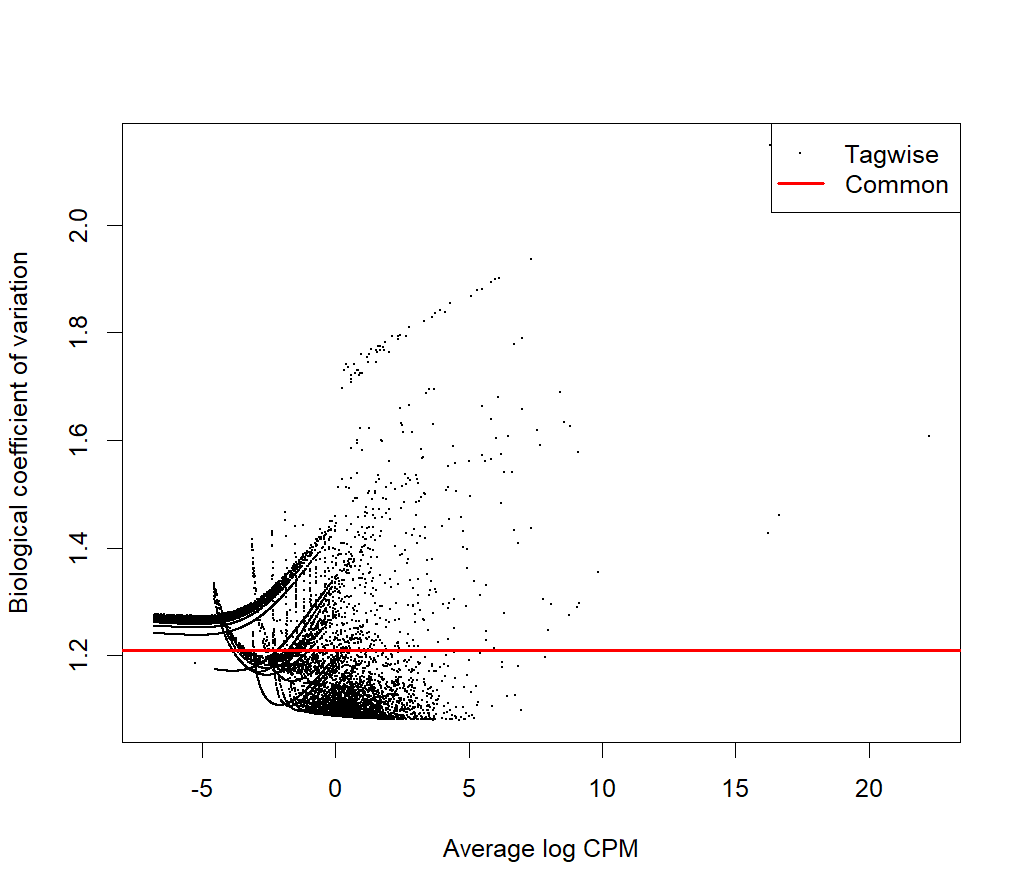

In [60]:
render('GLMtagdisp', main='BCV', plot='plotBCV')

In [61]:
r('fit <- glmFit(countlist,design)')
r('lrt <- glmLRT(fit,coef=2)')
r('edgeR_result <- topTags(lrt)')
print(r('edgeR_result'))

Coefficient:  group2 

         logFC    logCPM        LR       PValue       FDR

12728 7.709639 -1.286000 11.565989 0.0006716915 0.9366792

14106 7.105615 -2.625976  9.126539 0.0025192793 0.9366792

6015  6.995582 -2.622388  8.941355 0.0027878589 0.9366792

8119  6.798654 -2.615269  8.609189 0.0033447115 0.9366792

7434  6.297711 -1.586258  8.557289 0.0034414143 0.9366792

2478  6.569033 -2.015220  8.453481 0.0036434536 0.9366792

3086  6.404614 -3.567319  8.359266 0.0038372557 0.9366792

20892 6.404614 -3.567319  8.359266 0.0038372557 0.9366792

999   6.302303 -3.557350  8.142605 0.0043237132 0.9366792

4917  6.302303 -3.557350  8.142605 0.0043237132 0.9366792



In [21]:
r("write.csv(as.data.frame(edgeR_result), file='siggenes.csv', row.names = TRUE)"); # topTags(lrt,n=15000)

rpy2.rinterface.NULL

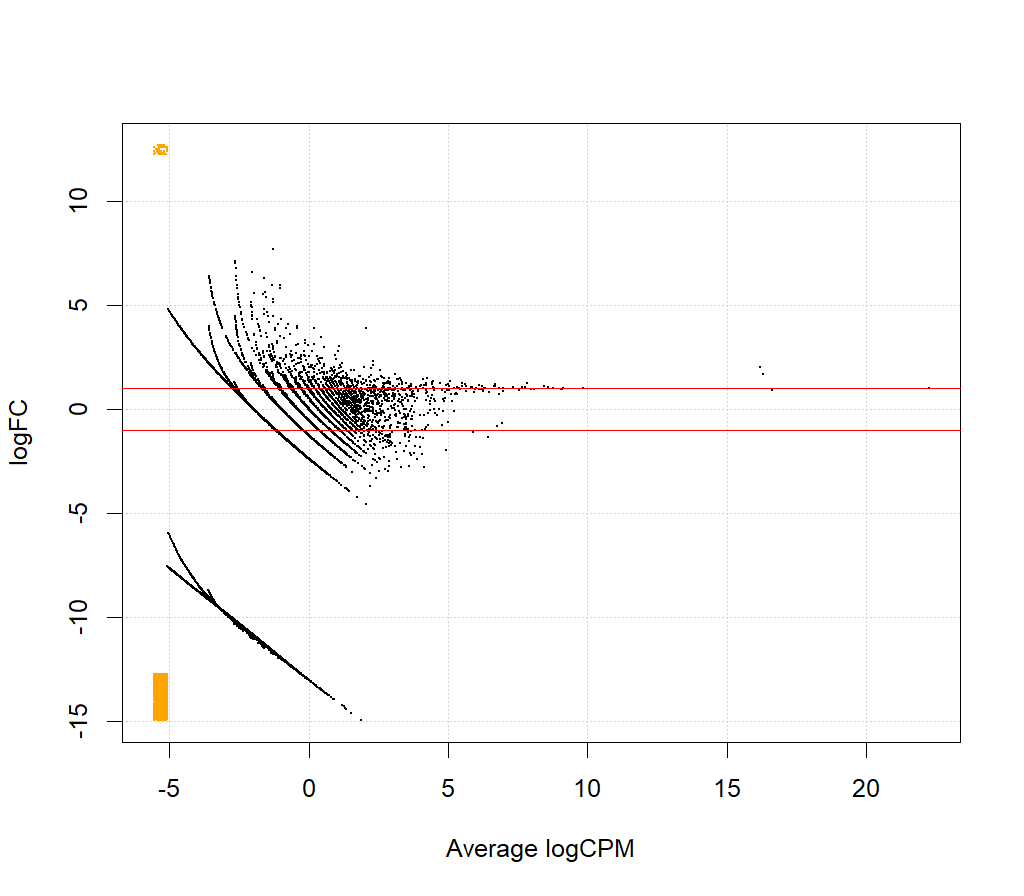

In [47]:
r('Genes <- decideTestsDGE(lrt, p=0.001)')
r('Genes <- rownames(lrt)[as.logical(Genes)]')
render('lrt', main='plotSmear', plot='plotSmear')

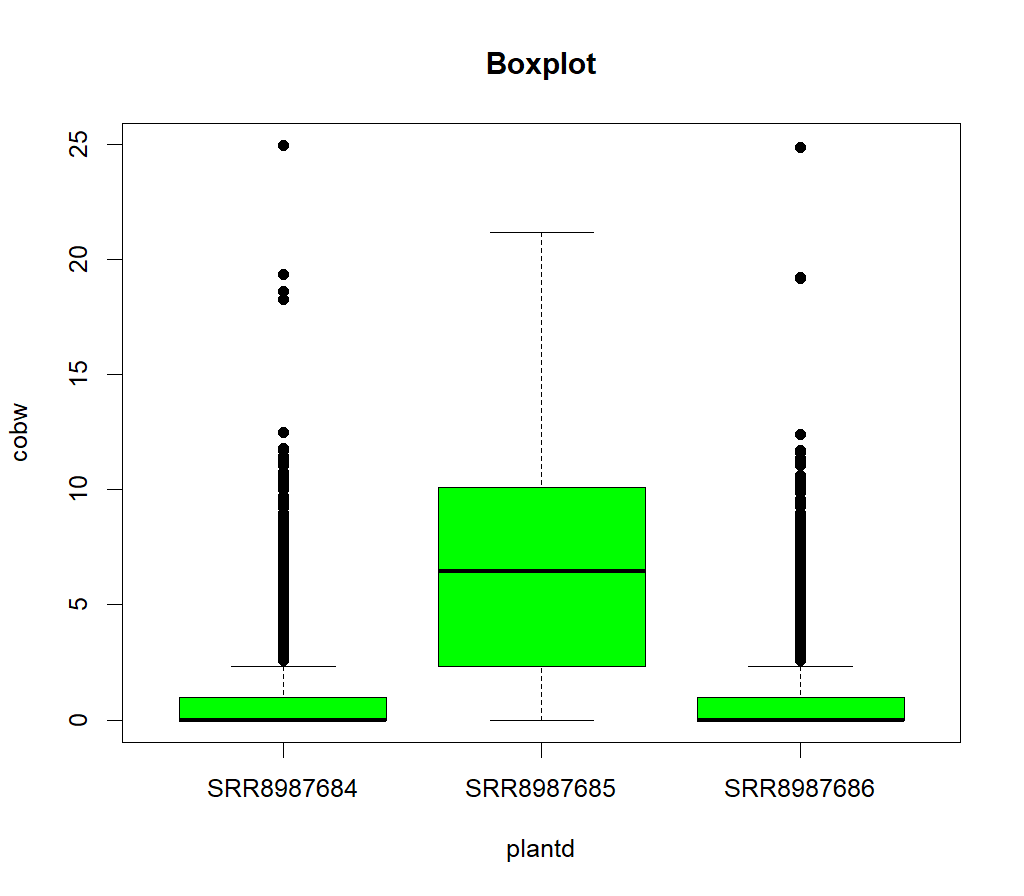

In [48]:
r('lm <- log2(m+1)')

r('lm <- na.omit(lm)')
r('m <- na.omit(m)')

r('pdf(paste0(fDir,"res.pdf"),width=10,height=10)')
 
render(r('lm'), main='Boxplot', plot='box')

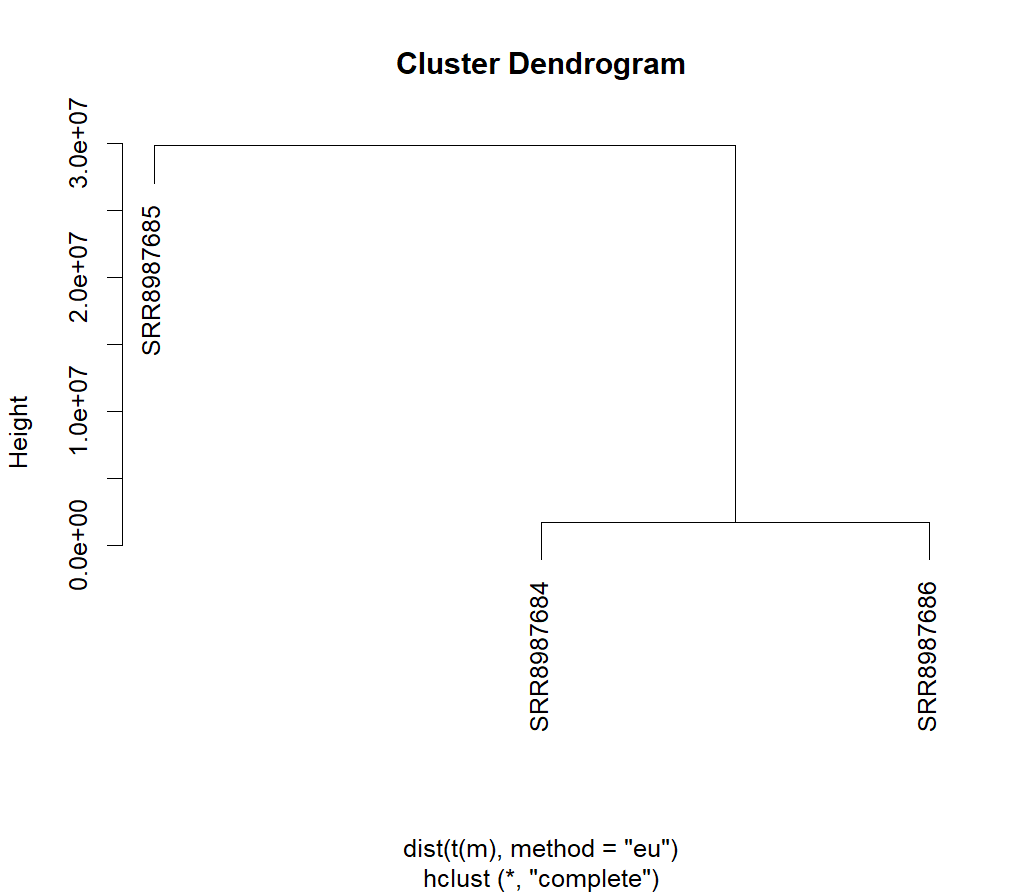

In [49]:
render(r('dist(t(m))'), plot='hclust')

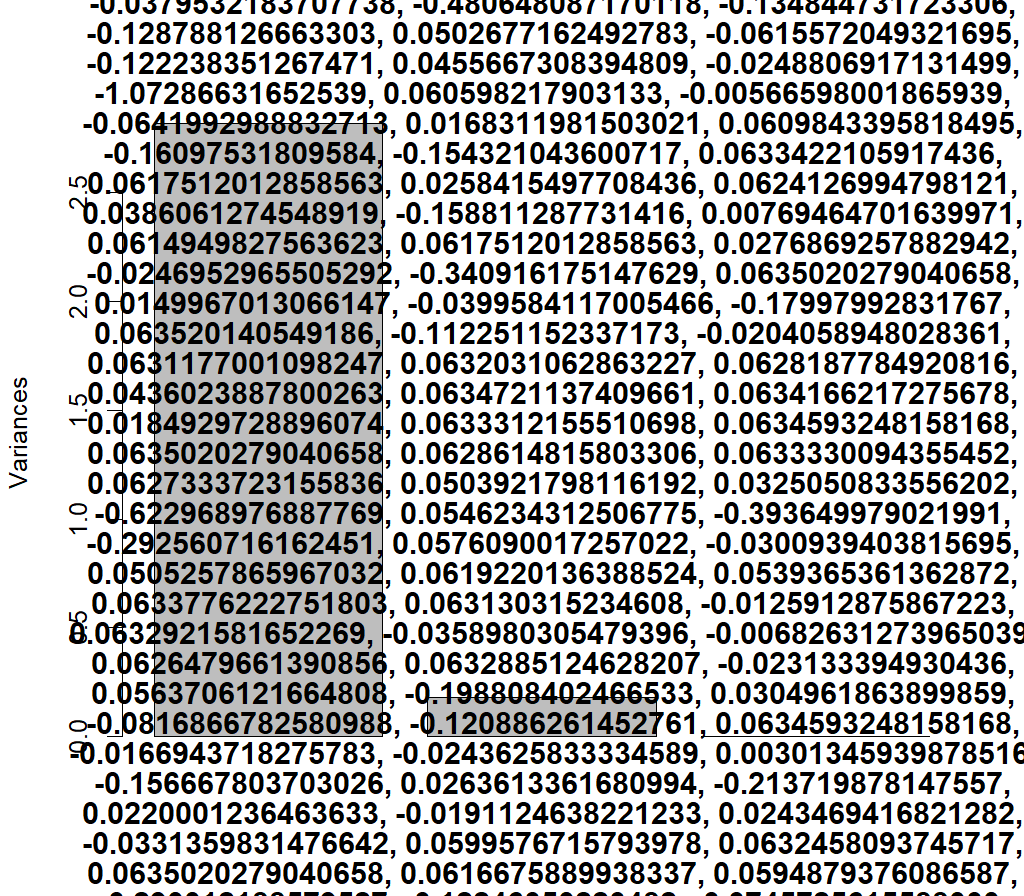

In [52]:
render('m', plot='prcomp')

In [53]:
print(r('summary(pr)'))

Importance of components:

                          PC1     PC2      PC3

Standard deviation     1.6787 0.42645 0.008277

Proportion of Variance 0.9394 0.06062 0.000020

Cumulative Proportion  0.9394 0.99998 1.000000



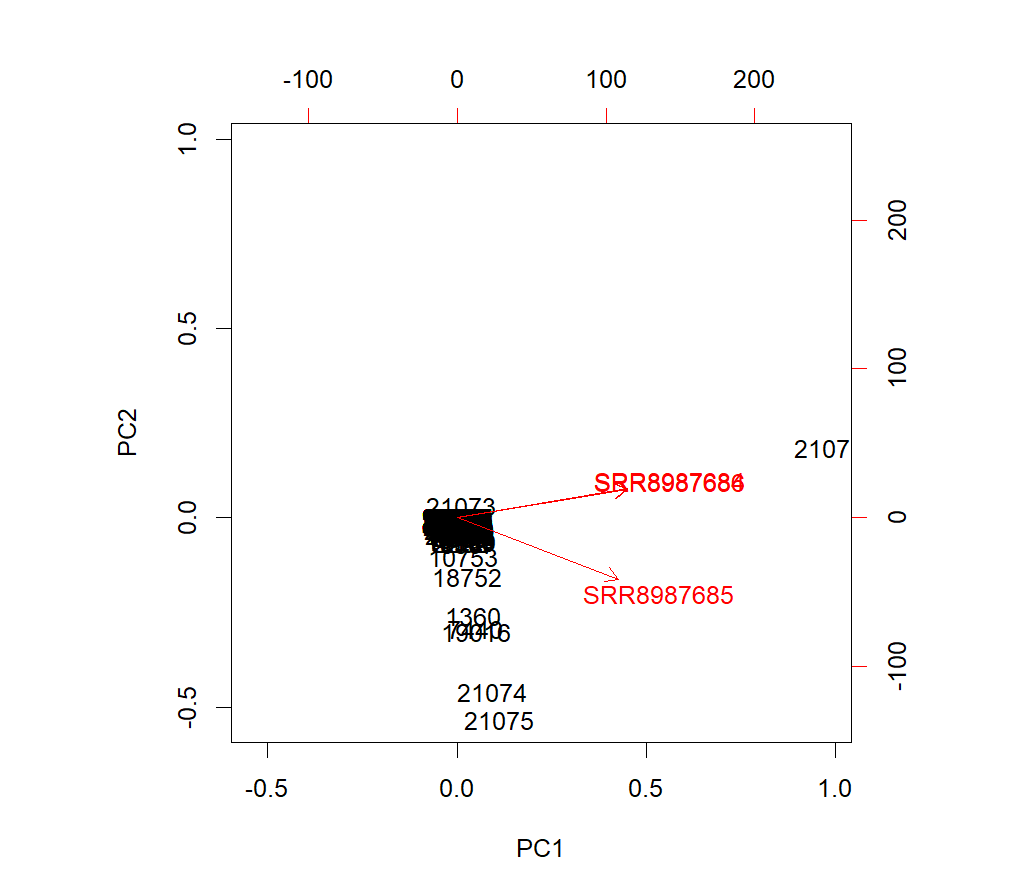

In [54]:
render(r('pr'), plot='biplot')
r('dev.off()'); # De ; is belangrijk zodat hij geen extra output cell geeft